# Agent

## Review

We built a router.

* Our chat model will decide to make a tool call or not based upon the user input
* We use a conditional edge to route to a node that will call our tool or simply end

## Goals

Now, we can extend this into a generic agent architecture.

In the above router, we invoked the model and, if it chose to call a tool, we returned a `ToolMessage` to the user.
 
But, what if we simply pass that `ToolMessage` *back to the model*?

We can let it either (1) call another tool or (2) respond directly.

This is the intuition behind [ReAct](https://react-lm.github.io/), a general agent architecture.
  
* `act` - let the model call specific tools 
* `observe` - pass the tool output back to the model 
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

This [general purpose architecture](https://blog.langchain.dev/planning-for-agents/) can be applied to many types of tools. 

![Screenshot 2024-08-21 at 12.45.43 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0b4a2c1e5e02f3e78b_agent2.png)

In [1]:
import os

from dotenv import load_dotenv

from langchain_openai import ChatOpenAI

load_dotenv()

True

In [2]:
# Here, we set parallel tool calling to false as math generally is done sequentially
# the OpenAI model specifically defaults to parallel tool calling for efficiency, see https://python.langchain.com/docs/how_to/tool_calling_parallel/
llm = ChatOpenAI(model='gpt-3.5-turbo-0125', parallel_tool_calls=False)

In [3]:
# create tools
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Add a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b
    
    Args:
        a: first int
        b: second int
    """

tools = [multiply, add, divide]
# bind the tool
llm_with_tools = llm.bind_tools(tools)

In [10]:
from IPython.display import Image, display
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def tool_calling_llm(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

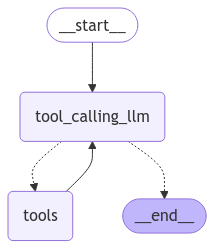

In [11]:
builder = StateGraph(MessagesState)

builder.add_node('tool_calling_llm', tool_calling_llm) 
builder.add_node('tools', ToolNode(tools)) # create the node that runs 'multiply' tool


builder.add_edge(START, 'tool_calling_llm')
builder.add_conditional_edges(
    'tool_calling_llm',
    tools_condition # to check if the last message has tool calls.
)
builder.add_edge('tools','tool_calling_llm')

react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [12]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

In [13]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_ETnJG7pa9uzk5ZEFPWACBPzK)
 Call ID: call_ETnJG7pa9uzk5ZEFPWACBPzK
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_dSzNUxgMtoRtYipogg3G4pid)
 Call ID: call_dSzNUxgMtoRtYipogg3G4pid
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (call_U0EGu9RX3YfQAaimcIqlBydy)
 Call ID: call_U0EGu9RX3YfQAaimcIqlBydy
  Args:
    a: 14
    b: 5
================================= Tool Message ===============

Here, we'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

## Memory

Now, we're going extend our agent by introducing memory.

In [14]:
messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_Zr4pOzMIreuX3UgxCHiuqclN)
 Call ID: call_Zr4pOzMIreuX3UgxCHiuqclN
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [15]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_XP2o2t3PKPeIsSyoDpGp3Nrh)
 Call ID: call_XP2o2t3PKPeIsSyoDpGp3Nrh
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: multiply

4
================================== Ai Message ==================================

The result of multiplying 2 by 2 is 4.


We don't retain memory of 7 from our initial chat!

This is because [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.
We can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 

LangGraph can use a checkpointer to automatically save the graph state after each step.
* This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. 
* One of the easiest checkpointers to use is the `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

In [16]:
from langgraph.checkpoint.memory import MemorySaver

In [18]:
checkpointer = MemorySaver()

react_graph_memory = builder.compile(checkpointer=checkpointer)

When we use memory, we need to specify a `thread_id`.

This `thread_id` will store our collection of graph states.

Here is a cartoon:

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread 
* We can access that thread in the future using the `thread_id`

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e0e9f526b41a4ed9e2d28b_agent-memory2.png)


In [19]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_c6E67hNiOmudBdGATxpYIavP)
 Call ID: call_c6E67hNiOmudBdGATxpYIavP
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


If we pass the same `thread_id`, then we can proceed from from the previously logged state checkpoint! 

In this case, the above conversation is captured in the thread.

The `HumanMessage` we pass (`"Multiply that by 2."`) is appended to the above conversation.

So, the model now know that `that` refers to the `The sum of 3 and 4 is 7.`.

In [20]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_c6E67hNiOmudBdGATxpYIavP)
 Call ID: call_c6E67hNiOmudBdGATxpYIavP
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_Q07xE2sSxsqGh1e4n7F5jhfu)
 Call ID: call_Q07xE2sSxsqGh1e4n7F5jhfu
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

When you multiply the

In [21]:
messages = [HumanMessage(content="Multiply that by 2.")]

config1 = {"configurable": {"thread_id": "3"}}
# if we use a different 'thread_id', then the agent does not remember previous
messages = react_graph_memory.invoke({"messages": messages}, config1)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_euMN6nogaPTQ52oTkaYXM5ON)
 Call ID: call_euMN6nogaPTQ52oTkaYXM5ON
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: multiply

4
================================== Ai Message ==================================

The result of multiplying 2 by 2 is 4.


In [23]:
messages = [HumanMessage(content="Multiply that by 2.")]

# if we use a different 'thread_id', then the agent does not remember previous
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_c6E67hNiOmudBdGATxpYIavP)
 Call ID: call_c6E67hNiOmudBdGATxpYIavP
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_Q07xE2sSxsqGh1e4n7F5jhfu)
 Call ID: call_Q07xE2sSxsqGh1e4n7F5jhfu
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

When you multiply the